# Regression

In [38]:
# import generic packages
import numpy as np
import pandas as pd
from IPython.display import display

# visualization packages
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

# module loading settings
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data frame

In [5]:
from sklearn.datasets import load_boston

raw = load_boston()
df = pd.DataFrame(raw['data'], columns=raw['feature_names'])
df['TARGET'] = raw['target']

print("{:d} samples".format(len(df)))
df.head()

506 samples


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [14]:
from pandas_profiling import ProfileReport

print(raw['DESCR'])

ProfileReport(df, correlation_overrides=list(df.columns))

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

Number of variables,14
Number of observations,506
Total Missing (%),0.0%
Total size in memory,55.4 KiB
Average record size in memory,112.1 B
Numeric,14
Categorical,0
Date,0
Text (Unique),0
Rejected,0
Distinct count,356


In [24]:
from sklearn.base import BaseEstimator, TransformerMixin

def to_circular_variable(df, col_name, cardinality):
    df["{:s}_SIN".format(col_name)] = df[col_name].apply(lambda x: sin(x / cardinality * 2 * pi))
    df["{:s}_COS".format(col_name)] = df[col_name].apply(lambda x: cos(x / cardinality * 2 * pi))
    return df

class FeatureAugmenter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X

augmenter = FeatureAugmenter()

y_col = 'TARGET'

y = df[y_col].values.ravel()
X = augmenter.transform(df.drop(y_col, axis=1, inplace=False))

# group for cross validation
groups = np.random.randint(1,10,len(y))

display(X.head())
print(X.columns.values)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


## Model

In [51]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, Imputer, StandardScaler

from sklearn.linear_model import SGDRegressor
from sklearn.dummy import DummyRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

from bdranalytics.pipeline.encoders import ColumnSelector, StringIndexer

# very careful here to not include target variables!
booleans = ['CHAS']
categoricals = ['RAD']
numericals =  ['CRIM','ZN','INDUS','NOX','RM','AGE','DIS','TAX','PTRATIO','B','LSTAT']

# specification of different model types and their defaults
model_dictionary = {'lr': SGDRegressor(loss='squared_loss'),
                    'xgb': XGBRegressor(n_estimators=100,
                                        objective='reg:linear', #'reg:gamma'
#                                         max_depth=9, 
#                                         reg_alpha=15,
#                                         reg_lambda=5, 
#                                         gamma=0.5
                                       ),
                    'gb': GradientBoostingRegressor(n_estimators=100),
                    'dummy': DummyRegressor(strategy='mean')
                   }

model_name = 'gb'

estimator = Pipeline([
        ('features', FeatureUnion(n_jobs=1,
                transformer_list=[
                    ('booleans', Pipeline([
                                ('selector', ColumnSelector(columns=booleans)),
                            ])),  # booleans close
                    ('categoricals', Pipeline([
                                ('selector', ColumnSelector(columns=categoricals)),
                                ('labeler', StringIndexer()),
                               # ('encoder', OneHotEncoder())
                            ])),  # categoricals close
                    
                    ('numericals', Pipeline([
                                ('selector', ColumnSelector(columns=numericals)),
                                ('imputer', Imputer()),
                                ('scaler', StandardScaler())
                            ])), # numericals close
                ],  # transformer_list close
            )),  # features close
        ('regressor', model_dictionary[model_name]),
])

estimator

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('booleans', Pipeline(steps=[('selector', ColumnSelector(columns=['CHAS']))])), ('categoricals', Pipeline(steps=[('selector', ColumnSelector(columns=['RAD'])), ('labeler', StringIndexer())])), ('numericals', Pipeline(steps=[('select...       presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False))])

## Parameter tuning

In [52]:
#from bdranalytics.model_selection.growingwindow import IntervalGrowingWindow
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV

# create a cross-validation routine for parameter tuning
cv_dev = GroupShuffleSplit(n_splits=3, test_size=0.1, train_size=0.1, random_state=11)
cv_test = GroupShuffleSplit(n_splits=1, test_size=0.1, train_size=None, random_state=22)

dev_indices, test_indices = next(cv_test.split(X, y, groups=groups))

# specification of the different model hyperparameters and tuning space
model_params_grid = {'lr': {'regressor__alpha': [1e-5, 1e-4, 1e-3]},
                     'xgb': {
                             'regressor__max_depth': [3,6,9],
                             'regressor__reg_alpha': [0,5,15],
                             'regressor__reg_lambda': [0,5,15],
                             'regressor__gamma' : [0,0.5,5,50],
                            },
                     'dummy': {'regressor__strategy':['mean','median']}
                    }

# tune model with a parameter grid search if desired
tune_model = False
n_jobs = 4
if tune_model:
    
    grid_search = GridSearchCV(estimator, cv=cv_dev, n_jobs=n_jobs, refit=False,
                             param_grid=model_params_grid[model_name],
                             verbose=1)

    grid_search.fit(X.iloc[dev_indices,:], y[dev_indices], groups=groups[dev_indices])
    
    # show grid search results
    display(pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score').head())
    
    # set best parameters for estimator
    estimator.set_params(**grid_search.best_params_)

## Validation

In [53]:
y_pred = [] 
y_true = []
y_period = []

# loop over the test folds
for i_fold, (train_index, test_index) in enumerate(cv_test.split(X, y, groups=groups)):
    
    print("validation fold {:d}".format(i_fold))
    
    X_train = X.iloc[train_index,:].copy()
    y_train = y[train_index]
    
    X_test = X.iloc[test_index,:].copy()
    y_test = y[test_index]
    
    # fit the model
    estimator.fit(X_train, y_train)

    # predict test samples
    y_pred.append(estimator.predict(X_test))
    
    # store the true y labels for each fold
    y_true.append(np.array(y_test))


# postprocess the results
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

validation fold 0


In [54]:
results = df.iloc[test_indices,:].copy()[[y_col]]
results['PREDICTION'] = y_pred

results['ABS_ERROR'] = (results[y_col] - results['PREDICTION']).abs()
results['REL_ERROR'] = results['ABS_ERROR'] / results[y_col]

print('Mean errors:')
display(results.filter(regex="ERROR").mean())
print('Median errors:')
display(results.filter(regex="ERROR").median())

Mean errors:


ABS_ERROR    2.417600
REL_ERROR    0.144902
dtype: float64

Median errors:


ABS_ERROR    1.602982
REL_ERROR    0.072111
dtype: float64

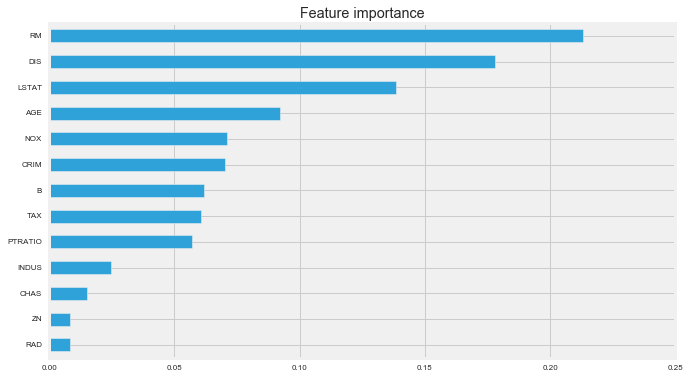

In [55]:
feature_labels = booleans + categoricals + numericals
n_features = len(feature_labels)

if model_name is 'lr':
    weights = estimator._final_estimator.coef_[0]
elif model_name in ['rf','gb']:
    weights = estimator._final_estimator.feature_importances_
    #stdevs = np.std([tree.feature_importances_ for tree in estimator._final_estimator.estimators_], axis=0)
elif model_name is 'xgb':
    importance_dictionary = estimator._final_estimator.booster().get_score(importance_type='weight')
    weights = [value for (key, value) in sorted(importance_dictionary.items())]
elif model_name is 'dummy':
    print('DummyRegressor does not have weights')
    weights = np.zeros(n_features)

feature_weights = pd.Series(weights, index=feature_labels).sort_values()
feature_weights.plot.barh(title='Feature importance', fontsize=8, figsize=(10,6), grid=True);

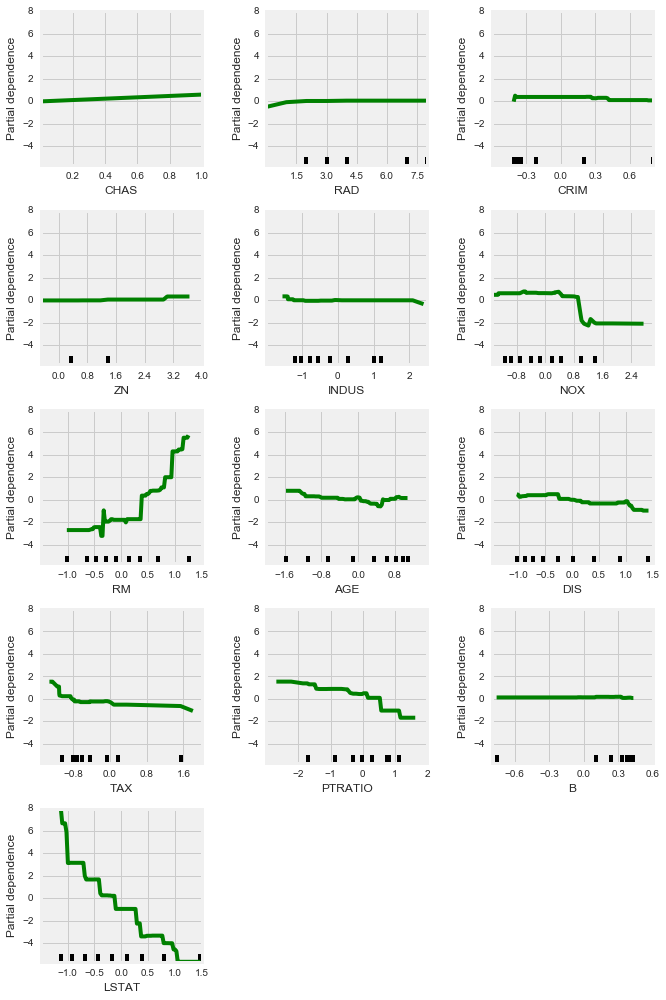

In [56]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

if model_name is 'gb':
    X_transformed = Pipeline(steps=estimator.steps[:-1]).fit_transform(X.iloc[dev_indices,:], y[dev_indices])
    plot_partial_dependence(estimator._final_estimator, X_transformed,
                            features=range(n_features), feature_names=feature_labels,
                            figsize=(10,24), n_cols=3, percentiles=(0.1,0.9));
else:
    print("No partial dependence plots available for this model type.")

In [57]:
new_data = {'CRIM':0.00632, 'ZN':18.0, 'INDUS':2.31, 'CHAS':False, 
            'NOX':0.538, 'RM':6.575, 'AGE':65.2, 'DIS':4.0900, 'RAD':1.0, 'TAX':296.0,
            'PTRATIO':15.3,'B':396.90, 'LSTAT':4.98,}
new_X = pd.DataFrame.from_dict([new_data])
estimator.predict(augmenter.transform(new_X))

array([ 25.79968322])

In [ ]:
import pickle
import dill

estimator.fit(X,y)
pickle.dump(estimator, open('../models/estimator.p', "wb" ), protocol=2)